# csRecoverySuite.py

This package provides a set of tools to reconstruct images from undersampled and noisy data in k-space. 

In [72]:
import sys
import numpy as np
import scipy
sys.path.append('../')

### Generating synthetic Fourier k-space observations

The steps below summarize how to use the tool. We first create synthetic undersampled and noisy Fourier measurements from a complex image, and then reconstruct it using the tools in the package. We start by reading an grayscale image using openCV.

Image size:  (256, 256)


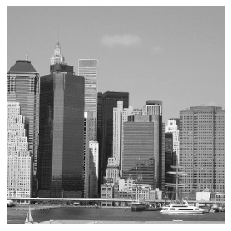

In [73]:
import cv2
from CSRecoverySuite import crop
import matplotlib.pyplot as plt
im = cv2.imread('city.png', cv2.IMREAD_GRAYSCALE)
im = crop(im)
plt.imshow(im,cmap='gray')
plt.axis('off')
print('Image size: ',im.shape)

The **crop()** function crops the image to power of 2 dimensions, so the wavelet transform provided by the *pywt* is orthogonal.
We then generate a Gaussian undersampling mask, using the *generateSamplingMask()* function, where **delta** is the undersampling ratio

Effective undersampling 0.2493133544921875


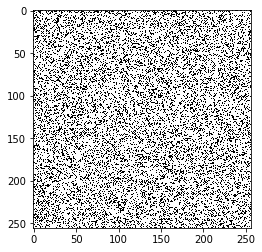

In [75]:
from CSRecoverySuite import generateSamplingMask

# Select an undesampling ratio
delta = 0.25
# Generate an undersampling mask
omega = generateSamplingMask(im.shape, delta, 'bernoulli')
# Verify the undersampling ratio
nsamp = np.sum((omega == 1).ravel())/np.prod(omega.shape)
print('Effective undersampling',nsamp)
# Plot mask
plt.imshow(omega[0],cmap='binary')

Possible choices are 

- **bernoulli**, each pixel in the mask is generate according to a Bernoulli random variable with probability *delta*.
- **vardentri**, variable density triangular.
- **vardengauss**
- **vardenexp**
- **halton**

We set the wavelet padding as

In [76]:
waveMode = 'periodization'

and compute the 2D Haar wavelet transform using

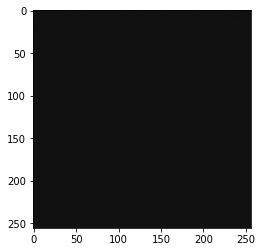

In [77]:
import pywt
from CSRecoverySuite import pywt2array
wim = pywt2array(pywt.wavedec2(im, wavelet='haar', mode=waveMode), im.shape)
plt.imshow(wim, cmap='gray')

### Introduction of a wavelet-Fourier operator
Non linear reconstruction is achieved with the solution of the following problem

In [82]:
from CSRecoverySuite import Operator4dFlow
A = Operator4dFlow(imsz=im.shape, insz=wim.shape, samplingSet=omega, waveletName='haar', waveletMode=waveMode)

# 
A.input_size()

(1, 256, 256)

In [83]:
A.shape()

TypeError: 'tuple' object is not callable

Once the operator is defined we can apply to any wavelet image using the overloaded ```*``` multiplication. 

c = A*b

b = A.T*c

A.getNorm()

B = A.colRestrict(idxSet)

#### Add noise to the Fourier data

yim = A*wim

We then define the noise level as

In [3]:
# Noisy data
nlevel      = nlevelVal
imNrm       = np.linalg.norm(im.ravel(), ord=2)
sigma       = nlevel * (imNrm / np.sqrt(2 * im.size))
y           = yim + sigma * (np.random.normal(size=yim.shape) + 1j * np.random.normal(size=yim.shape))

NameError: name 'nlevelVal' is not defined

#### Reconstruct original image from undersampled noisy Fourier measurements *yim*

In [4]:
# Recovery via orthogonal projection
#   FOURIER TRANSFORM NEEDS TO BE NORMALIZED
fim             = (im.size ** -1/2) * fft.fft2( im )
fim[~omega]     = 0
fim             = (im.size ** -1/2) * fft.ifft2( fim )

NameError: name 'im' is not defined


eta             = sigma * (np.sqrt(2 * nsamp) + 1.6)
cswim, fcwim = CSRecovery(eta, yim, A, np.zeros( wsz ), disp=3)
csim = pywt.waverec2(array2pywt(cswim), wavelet='haar', mode=waveMode)
```

```
deb_cswim, deb_fcwim = CSRecoveryDebiasing(yim, A, cswim)
deb_csim = pywt.waverec2(array2pywt(deb_cswim), wavelet='haar', mode=waveMode)
```

```
omp_cswim, omp_fcwim = OMPRecovery(A, yim, tol=5.0e-2)
omp_csim = pywt.waverec2(array2pywt(omp_cswim), wavelet='haar', mode=waveMode)
```

### Generating noisy samples

Use **vtktoimg.py** to generate a numpy file of velocity and magnitude from a vtk file.
* **directory**: location of vtk files
* **npydir**: location to store numpy files (2nd parameter)
* **sliceIndex**: index of slice (0,1,2) for ex. 0 for the orthogonal slice, and 2 for the second Poiseuille slice. (3rd parameter for command line arguments.)

``` 
python3 vtktoimg.py vtk/file/located/here save/numpy/here 2
```

Use **genSamples.py** to generate k-space, given velocity and magnitude. Undersample and add random noise.

Run main, changing parameters such that:

* **numRealizations**: number of noisy images
* **directory**: location of numpy files
* **uType**: undersampling type. options: 'halton','bernoulli', 'vardengauss', 'vardenexp', 'vardentri'

To generate 100 noisy realizations, execute
```
python3 genSamples.py 100 vardengauss numpy/files/saved/here
```

### Recovering Images
``` 
python3 recover.py 0.01 0.25 'bernoulli' 100 16 kspace/data/dir save/recovered/images/here/ pattern/dir/
```
where parameters are listed in order: 
* noise level: ex. 0.01 means 1% noise
* undersampled percentage: ex. 0.25 means 25% of the image not sampled
* undersampling type
* number of realizations: should match file name generated in genSamples.py
* number of processes

If running on CRC, be sure to include

``` setenv OMP_NUM_THREADS 1 ```

so the numerical libraries invoked by numpy use only 1 thread per code, not overloading the processors. 

If the saved numpy file of recovered images already exists, the code will default to loading the images from the file, rather than recovering the images again. 

## Post Processing
Files located in tests/07_PostProcess/ are used to generate plots of results, such as correlation plots and recovered images.

### Generating correlation plots

To plot all the correlations mentioned in the paper,without saving the numpy files, only the images of graphs, use
```
python3 corrplt.py 0.1 0.75 vardengauss 100 files/saved/here
```

To save only the correlations for a specific set, or to save numpy files containing all the correlations (as opposed to only the plots), use the file correlation.py

``` 
get_vals(noise_percent, undersampling_percent, num_realizations, size, num_pts, recdir, kspacedir, ptsdir) 
``` 
where:

* **size**: the maximum distance to compute correlations. Points are generated starting from distance 1 to distance ```size```
* **num_pts**: the number of points to average the correlation across. If num_pts = 20, then 20 pairs of points are selected for each distance d.

Or, to save all the correlation numpy files,
```
python3 correlation.py 200 50 recovered/images/dir/ where/to/save/chosen/points kspace/dir/
```
where the first two parameters are the size and num_pts.

### MSE Plot
To generate a violin plot of the mean squared error for all combinations of noise and undersampling pattern, execute
```
python3 mseplt.py 100 kspace/dir/ recovered/images/dir/
```
where 100 is the number of samples. Additionally, within main, options may be changed, depending on which histograms are desired. By default, all of these combinations will be generated.

* **use_complex**: whether to compare the MSE against the complex images, or images after velocity recovery
* **use_truth**: whether to compare the MSE against the true original, or the average recovered image

### Saving images

To save the recovered image examples, use 
```
python3 saveimgs.py 100 kspace/data/dir recovered/images/dir pattern/dir 
```